# Boat Type Classification  
Suggested algorithm to classify marine vessels from images using ResNet50 for feature extraction and LDA model for classification   
BY:  
Eddie Rudoy 313533341  
Odeia Busheri 206059156




In [1]:
!pip install --upgrade plotly
!pip install -U scikit-learn
!pip uninstall matplotlib -Y
!pip install matplotlib
# !pip instal sklearn_evaluation


Usage:   
  pip3 uninstall [options] <package> ...
  pip3 uninstall [options] -r <requirements file> ...

no such option: -Y


In [2]:
!pip install sklearn-evaluation

## Library Imports

In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/Boat_Classification'

import random
import os

import numpy as np
import pandas as pd
import PIL

import matplotlib.pyplot as plt
import plotly.express as px
import glob
import cv2

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet152
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import f1_score

import skimage.io as io
import torch

from statistics import mean
import time

/content/drive/MyDrive/Colab Notebooks/Boat_Classification


In [2]:
class Config: 
    """
    """
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    INPUT_PATH = '/content/drive/MyDrive/Colab Notebooks/Boat_Classification/VAIS'
    N_EPOCH = 30
    BATCH_SIZE = 32
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    IMG_SIZE = 224
    LABELS = ['EO_Files',
              'IR_Files',
              'FG_Labels',
              'Basic_Labels',
              'ID',
              'isTrain',
              'isNight'
              ]
    CLASSES = ['cargo', 'medium-other', 'passanger', 'sailing', 'small', 'tug']
    N_CLASSES = len(CLASSES),
    CLASS_THRESHOLD = 0.4,
    folders = ({
        'vi_train_images': os.path.join(INPUT_PATH, 'data_vi/train_images'), 
        'vi_test_images': os.path.join(INPUT_PATH, 'data_vi/test_images'),
        'ir_train_images': os.path.join(INPUT_PATH, 'data_ir/train_images'),
        'ir_test_images': os.path.join(INPUT_PATH, 'data_ir/test_images'),
        'all_train_images': os.path.join(INPUT_PATH, 'all_data/train_images'),
        'all_test_images': os.path.join(INPUT_PATH, 'all_data/test_images'),
    })

# Data import

In [7]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Boat_Classification/train.csv')

display(train_data)

,EO_Files,IR_Files,FG_Labels,Basic_Labels,ID,isTrain,isNight
0,jetski/jetski1/2014-06-25-13-56_00003-eo_img0_...,NaN,jetski,small,1,1,0
1,sailing-small-sails_up/sailboat3/2014-06-25-13...,NaN,sailing-small-sails_up,sailing,2,0,0
2,sailing-small-sails_up/sailboat4/2014-06-25-13...,NaN,sailing-small-sails_up,sailing,3,0,0
3,jetski/jetski1/2014-06-25-13-56_00006-eo_img0_...,NaN,jetski,small,1,1,0
4,sailing-small-sails_up/sailboat3/2014-06-25-13...,NaN,sailing-small-sails_up,sailing,2,0,0
...,...,...,...,...,...,...,...
1775,NaN,pleasure/pleasure31/2014-09-15-20-13_00010-ir_...,pleasure,small,116,0,1
1776,NaN,pleasure/pleasure31/2014-09-15-20-13_00015-ir_...,pleasure,small,116,0,1
1777,NaN,pleasure/pleasure31/2014-09-15-20-13_00020-ir_...,pleasure,small,116,0,1
1778,NaN,pleasure/pleasure30/2014-09-15-20-18_00020-ir_...,pleasure,small,117,0,1


# Data preprocessing

In [3]:
def import_data(path):
  """
  Import images from path, resize and convert to tensor and append to list
  Input-> path: '/content/drive/MyDrive/Colab Notebooks/Boat_Classification/VAIS/data/train_images/*'
  Output-> Image list & Labels list
  """
  images = []
  labels = [] 
  for directory_path in glob.glob(os.path.join(path, '*')):
    label = directory_path.split("\\")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (Config.IMG_SIZE, Config.IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = tf.convert_to_tensor(img)
        images.append(img)
        labels.append(label)

  images = np.array(images)
  labels = np.array(labels)

  return images, labels

### Encode labels

In [4]:
from sklearn import preprocessing

def label_encoder(labels):
  """
  Encoding labels
  Input-> train and test labels lists ['small', 'cargo']
  Output-> encoded labels [0, 1]
  """
  le = preprocessing.LabelEncoder()
  le.fit(labels)
  labels_encoded = le.transform(labels)

  return labels_encoded

## Import VI Data

Import visiable data images

In [5]:
train_vi_images, train_vi_labels = import_data(Config.folders['vi_train_images'])

In [ ]:
len(train_vi_images)

840

In [6]:
test_vi_images, test_vi_labels = import_data(Config.folders['vi_test_images'])

In [ ]:
len(test_vi_images)

735

In [7]:
train_vi_labels_encoded = label_encoder(train_vi_labels)
test_vi_labels_encoded = label_encoder(test_vi_labels)

In [25]:
train_vi_labels_encoded

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [8]:
#Split data into test and train datasets
x_vi_train, y_vi_train, x_vi_test, y_vi_test = train_vi_images, train_vi_labels_encoded, test_vi_images, test_vi_labels_encoded

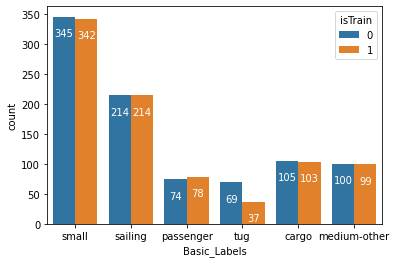

In [101]:
ax = sns.countplot(x='Basic_Labels', data=train_data, hue='isTrain')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)

In [89]:
lbl_count = train_data['Basic_Labels'].value_counts()
lbl_count

small           687
sailing         428
cargo           208
medium-other    199
passenger       152
tug             106
Name: Basic_Labels, dtype: int64

## Import IR Data

Import visiable data images

In [21]:
train_ir_images, train_ir_labels = import_data(Config.folders['ir_train_images'])

In [28]:
len(train_ir_images)

532

In [22]:
test_ir_images, test_ir_labels = import_data(Config.folders['ir_test_images'])

In [30]:
len(test_ir_images)

696

### Encode labels

In [23]:
train_ir_labels_encoded = label_encoder(train_ir_labels)
test_ir_labels_encoded = label_encoder(test_ir_labels)

In [24]:
#Split data into test and train datasets
x_ir_train, y_ir_train, x_ir_test, y_ir_test = train_ir_images, train_ir_labels_encoded, test_ir_images, test_ir_labels_encoded

## Import All Data

Import visiable data images

In [ ]:
train_all_images, train_all_labels = import_data(Config.folders['all_train_images'])

In [ ]:
len(train_all_images)

1372

In [ ]:
test_all_images, test_all_labels = import_data(Config.folders['all_test_images'])

In [ ]:
len(test_all_images)

1431

In [ ]:
train_all_labels_encoded = label_encoder(train_all_labels)
test_all_labels_encoded = label_encoder(test_all_labels)

In [ ]:
#Split data into test and train datasets
x_all_train, y_all_train, x_all_test, y_all_test = train_all_images, train_all_labels_encoded, test_all_images, test_all_labels_encoded

# Pretrained Models Train

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def data_generator(x, y):
  ""
  ""
  train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
  train_datagen.fit(x)

  train_generator = train_datagen.flow(
    x,
    y,
    batch_size = Config.BATCH_SIZE)
  
  return train_generator

In [ ]:
def cnn_model_train(model, data_generator, x_test, y_test):
  ""
  ""
  start = time.time()

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(
        data_generator,
        steps_per_epoch = 10,
        epochs = Config.N_EPOCH,
        validation_data = (x_test, y_test)
        )
  
  end = time.time()
  
  print(f'Train time {end - start} seconds')
  return history

In [ ]:
def plot_acc_loss(model_history):
  """
  Plot the training and validation accuracy and loss at each epoch
  input-> model_hisotry: model.history (model after fitting)
  output-> plot of training and validtion acc and loss
  """
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']
  plt.plot(epochs, acc, 'y', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  print(f'train acc: {mean(acc):.3f}, train loss: {mean(loss):.3f}, val acc: {mean(val_acc):.3f}, vall loss:{mean(val_loss):.3f}')


In [ ]:
train_vi_generator = data_generator(x_vi_train, y_vi_train)

In [ ]:
train_ir_generator = data_generator(x_ir_train, y_ir_train)

## ResNet152

### VI Images

In [ ]:
resnet152_vi_model = ResNet152(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
# train_vi_generator = data_generator(x_vi_train, y_vi_train)

In [ ]:
history_resnet152_vi = cnn_model_train(resnet152_vi_model, train_vi_generator, x_vi_test, y_vi_test)

Epoch 1/30
10/10 [==============================] - 40s 1s/step - loss: 4.0246 - accuracy: 0.4079 - val_loss: 4848.4570 - val_accuracy: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 9s 905ms/step - loss: 1.9795 - accuracy: 0.4803 - val_loss: 18745108.0000 - val_accuracy: 0.0000e+00
Epoch 3/30
10/10 [==============================] - 9s 926ms/step - loss: 1.6243 - accuracy: 0.4563 - val_loss: 24902808.0000 - val_accuracy: 0.0000e+00
Epoch 4/30
10/10 [==============================] - 9s 930ms/step - loss: 1.2640 - accuracy: 0.5437 - val_loss: 218244.2031 - val_accuracy: 0.2544
Epoch 5/30
10/10 [==============================] - 9s 936ms/step - loss: 1.0393 - accuracy: 0.6125 - val_loss: 4590.1279 - val_accuracy: 0.2544
Epoch 6/30
10/10 [==============================] - 9s 937ms/step - loss: 1.2274 - accuracy: 0.5875 - val_loss: 559.5515 - val_accuracy: 0.2449
Epoch 7/30
10/10 [==============================] - 9s 925ms/step - loss: 1.0201 - accuracy: 0.6250 - val_loss:

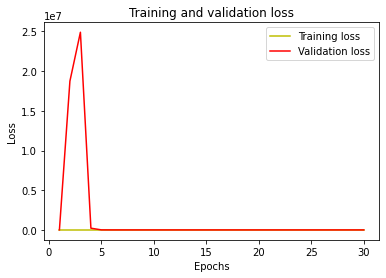

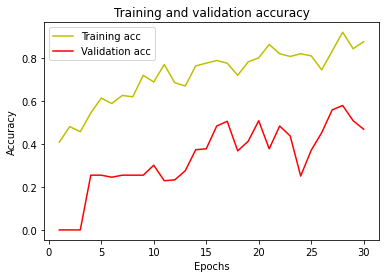

train acc: 0.720, train loss: 0.912, val acc: 0.335, vall loss:1462549.594


In [ ]:
plot_acc_loss(history_resnet152_vi)

### IR Images

In [ ]:
resnet152_ir_model = ResNet152(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
history_resnet152_ir = cnn_model_train(resnet152_ir_model, train_ir_generator, x_ir_test, y_ir_test)

Epoch 1/30
10/10 [==============================] - 28s 1s/step - loss: 4.2408 - accuracy: 0.2500 - val_loss: 426783.3438 - val_accuracy: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 10s 1s/step - loss: 1.8418 - accuracy: 0.3243 - val_loss: 5080735.5000 - val_accuracy: 0.0000e+00
Epoch 3/30
10/10 [==============================] - 9s 945ms/step - loss: 1.7860 - accuracy: 0.3750 - val_loss: 124167.1641 - val_accuracy: 0.3233
Epoch 4/30
10/10 [==============================] - 9s 950ms/step - loss: 1.5800 - accuracy: 0.4625 - val_loss: 4039.8865 - val_accuracy: 0.3233
Epoch 5/30
10/10 [==============================] - 9s 949ms/step - loss: 1.3037 - accuracy: 0.4938 - val_loss: 151.1375 - val_accuracy: 0.2744
Epoch 6/30
10/10 [==============================] - 9s 953ms/step - loss: 1.2238 - accuracy: 0.5813 - val_loss: 4.8539 - val_accuracy: 0.1997
Epoch 7/30
10/10 [==============================] - 9s 952ms/step - loss: 1.2464 - accuracy: 0.5500 - val_loss: 82.5428 - v

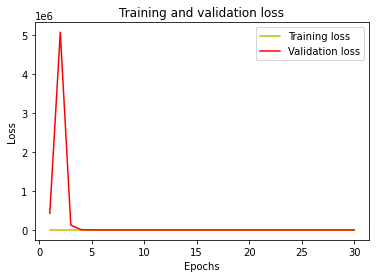

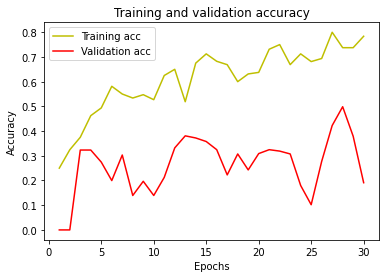

train acc: 0.611, train loss: 1.191, val acc: 0.265, vall loss:187871.650


In [ ]:
plot_acc_loss(history_resnet152_ir)

## ResNet50

### VI Images

In [ ]:
resnet50_vi_model = ResNet50(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
baseModel = ResNet50(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3), include_top=False)

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(Config.CLASSES), activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
history_resnet50_vi = cnn_model_train(model, train_vi_generator, x_vi_test, y_vi_test)

Epoch 1/30
10/10 [==============================] - 12s 581ms/step - loss: 1.3372 - accuracy: 0.5938 - val_loss: 7.8236 - val_accuracy: 0.3660
Epoch 2/30
10/10 [==============================] - 4s 447ms/step - loss: 1.2938 - accuracy: 0.5395 - val_loss: 113.5277 - val_accuracy: 0.4204
Epoch 3/30
10/10 [==============================] - 5s 477ms/step - loss: 1.1267 - accuracy: 0.6687 - val_loss: 123.1658 - val_accuracy: 0.4204
Epoch 4/30
10/10 [==============================] - 5s 476ms/step - loss: 0.9186 - accuracy: 0.7250 - val_loss: 72.5659 - val_accuracy: 0.4966
Epoch 5/30
10/10 [==============================] - 5s 468ms/step - loss: 0.9408 - accuracy: 0.6938 - val_loss: 128.0463 - val_accuracy: 0.4313
Epoch 6/30
10/10 [==============================] - 5s 465ms/step - loss: 0.8677 - accuracy: 0.7188 - val_loss: 94.5072 - val_accuracy: 0.4204
Epoch 7/30
10/10 [==============================] - 5s 471ms/step - loss: 0.9359 - accuracy: 0.6938 - val_loss: 40.5383 - val_accuracy: 0.2

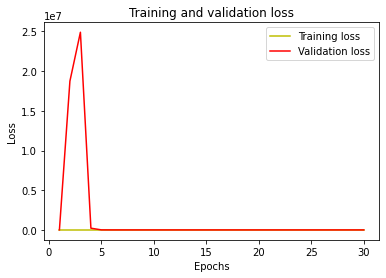

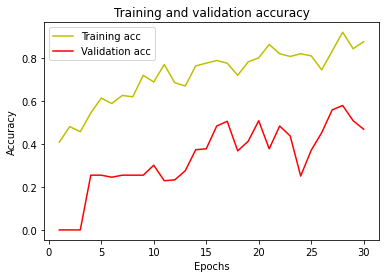

train acc: 0.720, train loss: 0.912, val acc: 0.335, vall loss:1462549.594


In [ ]:
plot_acc_loss(history_resnet152_vi)

### IR Images

In [ ]:
resnet50_ir_model = ResNet50(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
history_resnet50_ir = cnn_model_train(resnet50_ir_model, train_ir_generator, x_ir_test, y_ir_test)

Epoch 1/30
10/10 [==============================] - 10s 533ms/step - loss: 4.0272 - accuracy: 0.2703 - val_loss: 14.4878 - val_accuracy: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 4s 433ms/step - loss: 2.1742 - accuracy: 0.4000 - val_loss: 9478.5518 - val_accuracy: 0.0000e+00
Epoch 3/30
10/10 [==============================] - 4s 422ms/step - loss: 1.5043 - accuracy: 0.4324 - val_loss: 2816.1086 - val_accuracy: 0.0000e+00
Epoch 4/30
10/10 [==============================] - 4s 441ms/step - loss: 1.5028 - accuracy: 0.4750 - val_loss: 232.9572 - val_accuracy: 0.0000e+00
Epoch 5/30
10/10 [==============================] - 4s 438ms/step - loss: 1.4369 - accuracy: 0.5250 - val_loss: 32.4686 - val_accuracy: 0.0287
Epoch 6/30
10/10 [==============================] - 4s 441ms/step - loss: 1.0734 - accuracy: 0.6375 - val_loss: 39.8362 - val_accuracy: 0.1437
Epoch 7/30
10/10 [==============================] - 4s 449ms/step - loss: 1.2193 - accuracy: 0.5541 - val_loss: 185.2094

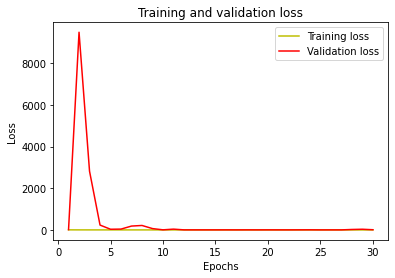

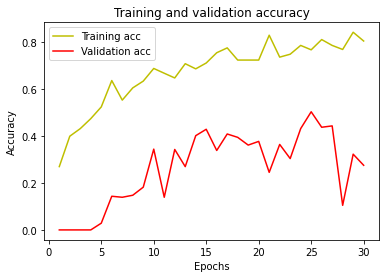

train acc: 0.675, train loss: 1.016, val acc: 0.263, vall loss:440.998


In [ ]:
plot_acc_loss(history_resnet50_ir)

## VGG19

### VI Images

In [ ]:
vgg19_vi_model = VGG19(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
history_vgg19_vi = cnn_model_train(vgg19_vi_model, train_vi_generator, x_vi_test, y_vi_test)

Epoch 1/30
10/10 [==============================] - 17s 1s/step - loss: 140.6825 - accuracy: 0.2125 - val_loss: 1.9641 - val_accuracy: 0.3605
Epoch 2/30
10/10 [==============================] - 7s 712ms/step - loss: 1.8281 - accuracy: 0.3063 - val_loss: 1.5431 - val_accuracy: 0.4490
Epoch 3/30
10/10 [==============================] - 9s 972ms/step - loss: 1.9127 - accuracy: 0.3355 - val_loss: 1.7297 - val_accuracy: 0.2122
Epoch 4/30
10/10 [==============================] - 7s 713ms/step - loss: 1.6546 - accuracy: 0.3875 - val_loss: 1.5357 - val_accuracy: 0.4082
Epoch 5/30
10/10 [==============================] - 7s 702ms/step - loss: 1.5751 - accuracy: 0.3487 - val_loss: 1.5268 - val_accuracy: 0.4204
Epoch 6/30
10/10 [==============================] - 7s 710ms/step - loss: 1.5109 - accuracy: 0.4000 - val_loss: 1.5565 - val_accuracy: 0.3660
Epoch 7/30
10/10 [==============================] - 7s 711ms/step - loss: 1.4639 - accuracy: 0.4187 - val_loss: 1.5849 - val_accuracy: 0.4354
Epoch 

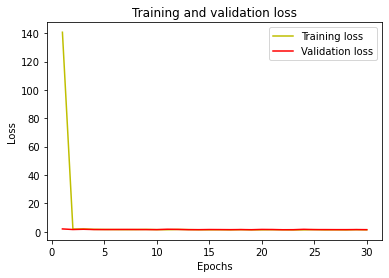

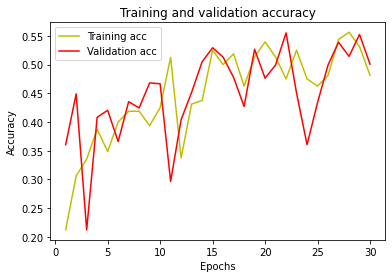

train acc: 0.449, train loss: 6.086, val acc: 0.451, vall loss:1.539


In [ ]:
plot_acc_loss(history_vgg19_vi)

### IR Images

In [ ]:
vgg19_ir_model = VGG19(weights='imagenet', input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

In [ ]:
history_vgg19_ir = cnn_model_train(vgg19_ir_model, train_ir_generator, x_ir_test, y_ir_test)

Epoch 1/30
10/10 [==============================] - 12s 1s/step - loss: 535.4644 - accuracy: 0.2027 - val_loss: 2.4243 - val_accuracy: 0.1394
Epoch 2/30
10/10 [==============================] - 7s 688ms/step - loss: 1.9090 - accuracy: 0.2973 - val_loss: 1.8188 - val_accuracy: 0.3233
Epoch 3/30
10/10 [==============================] - 7s 685ms/step - loss: 1.9028 - accuracy: 0.1875 - val_loss: 1.9025 - val_accuracy: 0.2371
Epoch 4/30
10/10 [==============================] - 7s 671ms/step - loss: 1.6745 - accuracy: 0.3176 - val_loss: 1.7349 - val_accuracy: 0.2256
Epoch 5/30
10/10 [==============================] - 7s 678ms/step - loss: 1.6602 - accuracy: 0.2973 - val_loss: 1.7128 - val_accuracy: 0.3362
Epoch 6/30
10/10 [==============================] - 7s 681ms/step - loss: 1.6821 - accuracy: 0.2875 - val_loss: 1.8007 - val_accuracy: 0.3563
Epoch 7/30
10/10 [==============================] - 6s 675ms/step - loss: 2.1132 - accuracy: 0.2703 - val_loss: 1.8058 - val_accuracy: 0.2759
Epoch 

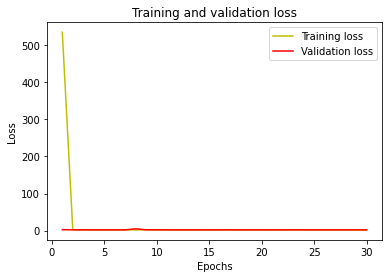

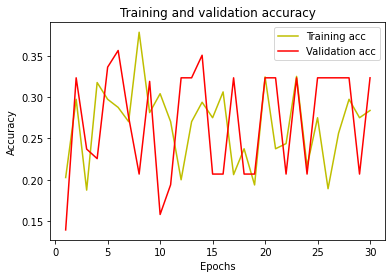

train acc: 0.267, train loss: 19.560, val acc: 0.271, vall loss:1.901


In [ ]:
plot_acc_loss(history_vgg19_ir)

In [ ]:
history_resnet152_vi.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Compare Models

In [ ]:
# show the accuracy by model
models_dict= {'resnet152_vi': history_resnet152_vi, 
             'resnet152_ir': history_resnet152_ir, 
             'resnet50_vi': history_resnet50_vi, 
              'resnet50_ir': history_resnet50_ir,
              'vgg19_vi': history_vgg19_vi, 
              'vgg19_ir': history_vgg19_ir,
              }

def show_accuracy_by_model(models):
    accuracy_df = pd.DataFrame(columns=['model_name', 'split', 'accuracy'])

    for model_name, model in models.items():
        accuracy_df.loc[len(accuracy_df)] = [model_name, 'train', mean(model.history['accuracy'])]
        accuracy_df.loc[len(accuracy_df)] = [model_name, 'val', mean(model.history['val_accuracy'])]

    fig = px.bar(accuracy_df, x='model_name', y='accuracy', color='split', barmode='group')
    # img_bytes = fig.to_image(format="png", width=600, height=350, scale=2)
    display(fig)
    # display(Image(img_bytes))

show_accuracy_by_model(models_dict)

# Feature Extaction & Dimension Reduction Model

## ResNet50 + LDA

In [12]:
def feature_extractor(model, x):
  """
  Input->model, data
  Output-> extracted features from CNN
  """
  start = time.time()

  for layer in model.layers:
	  layer.trainable = False
    
  extractor = model.predict(x)
  features = extractor.reshape(extractor.shape[0], -1)

  end = time.time()
  print(f'Feature Extraction time {end - start} seconds')

  return features

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def train_lda_model(x_train, y_train, lda_model=LinearDiscriminantAnalysis()):
  """
  input: x_train, y_train, lada_model
  outfout: trained model on selected data
  """
  start = time.time()

  lda_model = lda_model.fit(x_train, y_train)
  y_prediction = lda_model.predict(x_train)

  end = time.time()

  print(f'LDA model train time {end - start} seconds')

  acc_score = lda_model.score(x_train, y_train)
  f1 = f1_score(y_train, y_prediction, average='micro')
  print(f'Model acc score: {acc_score}')
  print(f'Model F1 score: {f1}')

  return lda_model

In [11]:
def test_model(x_test, cnn_model, lda_model):
  """
  input: x_test, cnn_model, lda_model
  output: the prediction of the model on the test set
  """
  X_test_features = feature_extractor(cnn_model, x_test)

  #Now predict using the trained RF model. 
  prediction = lda_model.predict(X_test_features)

  return prediction

In [16]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(
    y_test, 
    y_pred_proba, 
    threshold=Config.CLASS_THRESHOLD, 
    label_names=Config.CLASSES
)-> None:
    """
    """
    # y_pred = np.where(y_pred_proba > threshold, 1, 0)
    c_matrices = multilabel_confusion_matrix(y_test, y_pred_proba)
    
    cmap = plt.get_cmap('Blues')
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    for cm, label, ax in zip(c_matrices, label_names, axes.flatten()):
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=cmap);

        ax.set_xlabel('Predicted labels');
        ax.set_ylabel('True labels'); 
        ax.set_title(f'{label}');

    plt.tight_layout()    
    plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_map(y_test, y_pred):
#Confusion Matrix - verify accuracy of each class
  # cm = confusion_matrix(y_test, prediction_RF)
  cm = confusion_matrix(y_test, y_pred)
  #print(cm)
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, square=True, xticklabels=Config.CLASSES, yticklabels=Config.CLASSES, fmt='.3g')
  plt.show()


In [18]:
from sklearn_evaluation import plot
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def show_learning_curve(model, X, t, cv, n_jobs=1):
  train_sizes, train_scores, test_scores = learning_curve(
    model, X, t, cv=cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5))
  plot.learning_curve(train_scores, test_scores, train_sizes)
  plt.show()

### VI Images

In [14]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# x_train_features = feature_extractor(model, x_vi_train)

In [15]:
# x_train_features = feature_extractor(model, x_vi_train)

In [16]:
x_train_features = feature_extractor(resnet50_model, x_vi_train)

Feature Extraction time 10.737504243850708 seconds


In [119]:
len(x_train_features)

840

In [21]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

In [17]:
lda_model = LinearDiscriminantAnalysis()

In [ ]:
# lda_model = train_lda_model(x_train_features, y_all_train, lda_model)

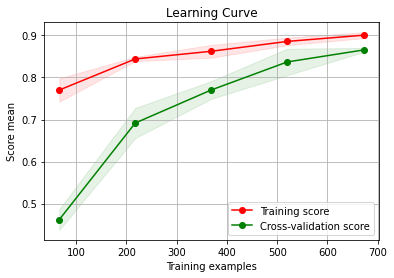

In [23]:
show_learning_curve(lda_model, x_train_features, y_vi_train, cv)

In [18]:
lda_model = train_lda_model(x_train_features, y_vi_train, lda_model)

LDA model train time 45.876688718795776 seconds
Model acc score: 0.9154761904761904
Model F1 score: 0.9154761904761906


In [35]:
from sklearn.metrics import classification_report

In [41]:
from numpy.lib.function_base import average
#Send test data through same feature extractor process and predict the test accuracy

prediction = test_model(x_vi_test, resnet50_model, lda_model)

#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(y_vi_test, prediction))
f1_test = f1_score(y_vi_test, prediction, average='micro')
print(f'F1 Score = {f1_test}')

Accuracy =  0.7918367346938775
F1 Score = 0.7918367346938775


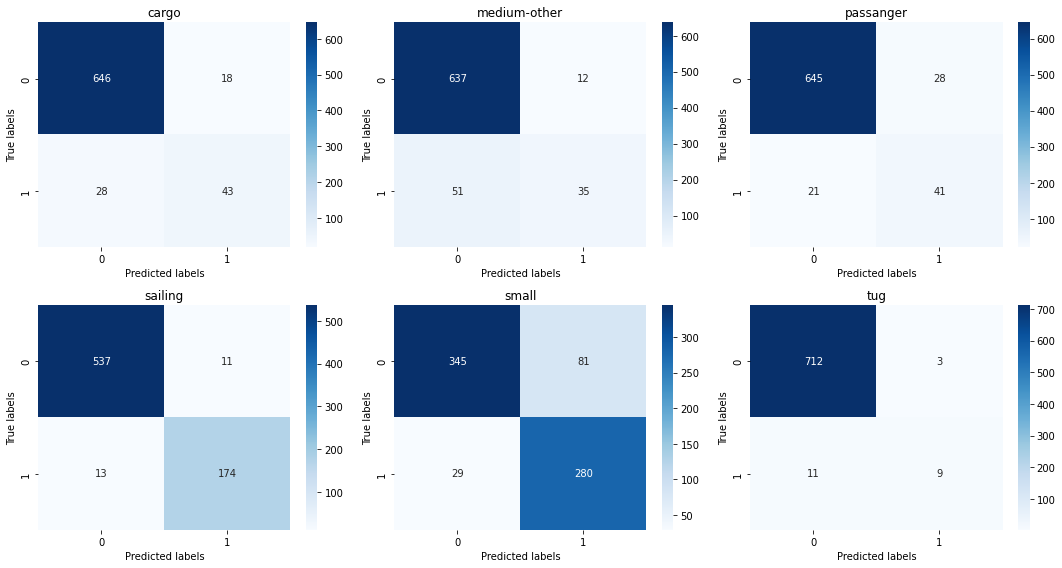

In [ ]:
plot_confusion_matrix(y_vi_test, prediction)

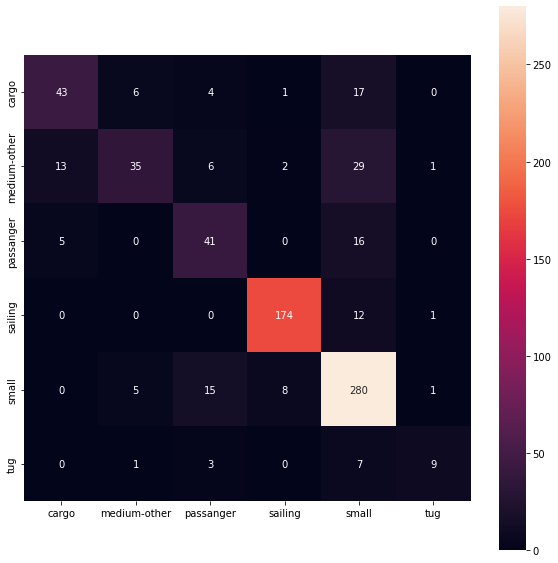

In [42]:
plot_confusion_matrix_map(y_vi_test, prediction)

In [44]:
print(classification_report(y_vi_test, prediction, target_names=Config.CLASSES))

              precision    recall  f1-score   support

       cargo       0.70      0.61      0.65        71
medium-other       0.74      0.41      0.53        86
   passanger       0.59      0.66      0.63        62
     sailing       0.94      0.93      0.94       187
       small       0.78      0.91      0.84       309
         tug       0.75      0.45      0.56        20

    accuracy                           0.79       735
   macro avg       0.75      0.66      0.69       735
weighted avg       0.79      0.79      0.78       735



### IR Images

In [25]:
x_ir_train_features = feature_extractor(resnet50_model, x_ir_train)

Feature Extraction time 1.281146764755249 seconds


In [26]:
lda_ir_model = LinearDiscriminantAnalysis()

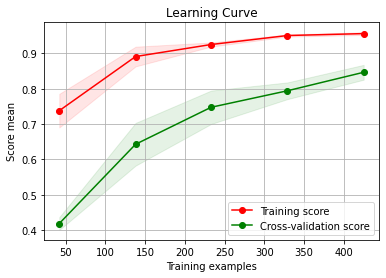

In [34]:
show_learning_curve(lda_model, x_ir_train_features, y_ir_train, cv)

In [27]:
lda_ir_model = train_lda_model(x_ir_train_features, y_ir_train, lda_ir_model)

LDA model train time 23.932788133621216 seconds
Model acc score: 0.9548872180451128
Model F1 score: 0.9548872180451128


In [50]:
from numpy.lib.function_base import average
#Send test data through same feature extractor process
# X_test_feature = feature_extractor(x_vi_test)

#Now predict using the trained RF model. 
# prediction = test_model(x_vi_test, resnet50_model, lda_model)
prediction_ir = test_model(x_ir_test, resnet50_model, lda_ir_model)
#Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(y_ir_test, prediction_ir))
f1_test = f1_score(y_ir_test, prediction_ir, average='micro')
print(f'F1 Score = {f1_test}')

Accuracy =  0.5201149425287356
F1 Score = 0.5201149425287356


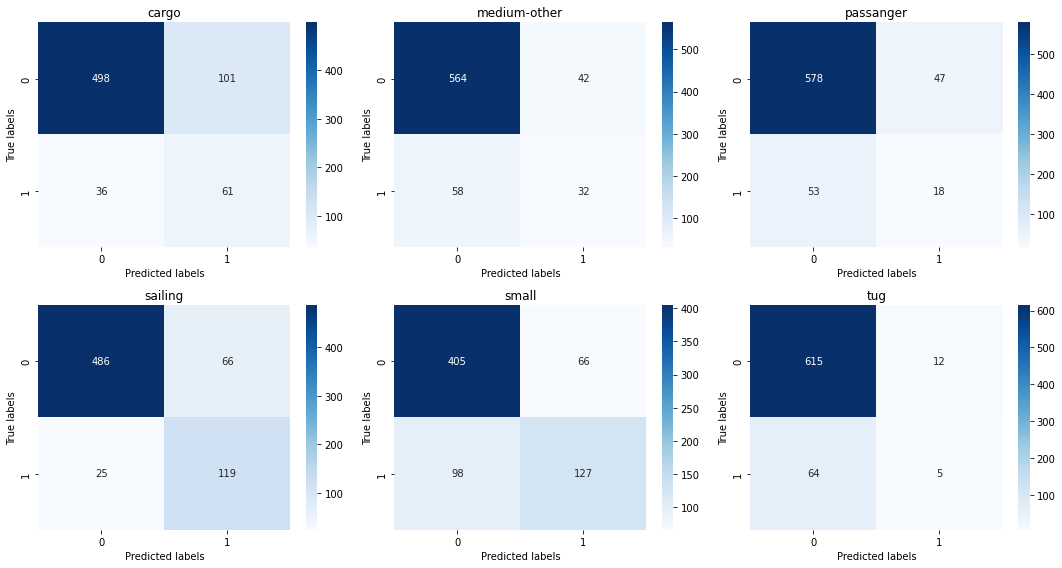

In [111]:
plot_confusion_matrix(y_ir_test, prediction_ir)

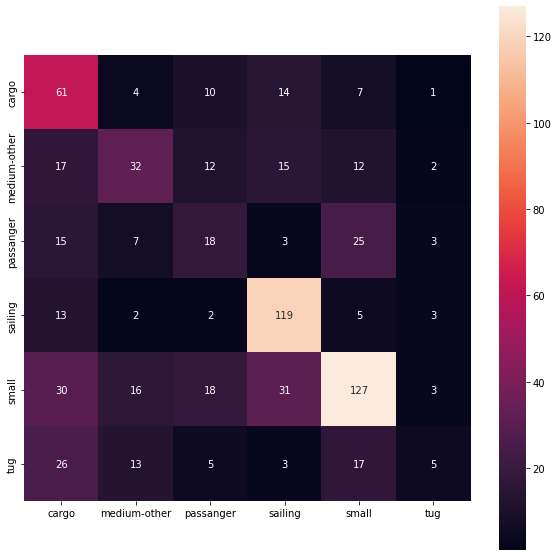

In [51]:
plot_confusion_matrix_map(y_ir_test, prediction_ir)

In [52]:
print(classification_report(y_ir_test, prediction_ir, target_names=Config.CLASSES))

              precision    recall  f1-score   support

       cargo       0.38      0.63      0.47        97
medium-other       0.43      0.36      0.39        90
   passanger       0.28      0.25      0.26        71
     sailing       0.64      0.83      0.72       144
       small       0.66      0.56      0.61       225
         tug       0.29      0.07      0.12        69

    accuracy                           0.52       696
   macro avg       0.45      0.45      0.43       696
weighted avg       0.51      0.52      0.50       696

